In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')

In [61]:
train = pd.read_csv('C:/projects/Facu/loan-approval-prediction/data/train_mod.csv')
test = pd.read_csv('C:/projects/Facu/loan-approval-prediction/data/test_mod.csv')

test_id = test['id']

In [62]:
X = train.drop(['loan_status', 'id'], axis=1)
y = train['loan_status']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

vars_cat = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
vars_num = X_train.select_dtypes(include=['float64', 'int64']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, vars_num),
    ('cat', categorical_transformer, vars_cat),
])

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)

In [63]:
X_train.shape

(41045, 31)

In [64]:
from scipy import stats
from imblearn.pipeline import Pipeline

pasos = [('balanced', SMOTE()),
    ('xgb', XGBClassifier())]

pipe = Pipeline(pasos)

pipe.fit(X_train, y_train)

pipe._final_estimator

y_pred = pipe.predict(X_val)

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     15055
           1       0.90      0.74      0.82      2537

    accuracy                           0.95     17592
   macro avg       0.93      0.87      0.89     17592
weighted avg       0.95      0.95      0.95     17592



In [65]:
folds=StratifiedKFold(n_splits=5,shuffle=True, random_state=42)

param_dist = {'xgb__max_depth': stats.randint(1,50),
              'xgb__learning_rate': stats.uniform(0.01, 0.5),
              'xgb__subsample': stats.uniform(0.1, 1),
              'xgb__colsample_bytree': stats.uniform(0.1, 1),
              'xgb__min_child_weight': stats.randint(1,4),
              'xgb__n_estimators': stats.randint(50, 1000)
             }

param_grid = [{'balanced':[SMOTE(), None]}]
param_grid[0].update(param_dist) 

xgb_random = RandomizedSearchCV(pipe, param_grid, cv=folds, verbose=1, n_jobs=7,scoring='roc_auc',n_iter=20,random_state=42)
xgb_random.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('balanced', SMOTE()),
                                             ('xgb',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric=None,
                                                            feature_typ...
                                         'xgb__min_child_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000252F23A3A90>,
                                         'xgb__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000252F239D2E0>,
                                         'xgb__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000252F266D040>}],
                   random_state=42, scoring='roc_auc', verbose=1)

In [66]:
print('Score: ',xgb_random.best_score_)
xgb_random.best_estimator_

Score:  0.9474741292438015


Pipeline(steps=[('balanced', None),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=np.float64(0.2996737821583597),
                               device=None, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=np.float64(0.2671172192068058),
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=868,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, ...))])

In [67]:
lista_params=xgb_random.cv_results_['params']

for i,el in enumerate(lista_params):
    lista_params[i]['ranking']=xgb_random.cv_results_['rank_test_score'][i]
    lista_params[i]['mean_score']=xgb_random.cv_results_['mean_test_score'][i]
sorted(lista_params, key=lambda d: d['ranking']) 

[{'balanced': None,
  'xgb__colsample_bytree': np.float64(0.2996737821583597),
  'xgb__learning_rate': np.float64(0.2671172192068058),
  'xgb__max_depth': 3,
  'xgb__min_child_weight': 1,
  'xgb__n_estimators': 868,
  'xgb__subsample': np.float64(0.7803075385877797),
  'ranking': np.int32(1),
  'mean_score': np.float64(0.9474741292438015)},
 {'balanced': None,
  'xgb__colsample_bytree': np.float64(0.49106060757324077),
  'xgb__learning_rate': np.float64(0.10111804389403116),
  'xgb__max_depth': 4,
  'xgb__min_child_weight': 2,
  'xgb__n_estimators': 439,
  'xgb__subsample': np.float64(0.3079416628681888),
  'ranking': np.int32(2),
  'mean_score': np.float64(0.9452647710016511)},
 {'balanced': SMOTE(),
  'xgb__colsample_bytree': np.float64(0.6398410913016731),
  'xgb__learning_rate': np.float64(0.1115306123673847),
  'xgb__max_depth': 13,
  'xgb__min_child_weight': 3,
  'xgb__n_estimators': 748,
  'xgb__subsample': np.float64(0.7947849330397045),
  'ranking': np.int32(3),
  'mean_score'

In [68]:
y_pred = xgb_random.predict(X_val)

print('ROC-AUC score:',round(roc_auc_score(y_val, y_pred),4))

ROC-AUC score: 0.8616


In [69]:
xgb_random.best_params_

{'balanced': None,
 'xgb__colsample_bytree': np.float64(0.2996737821583597),
 'xgb__learning_rate': np.float64(0.2671172192068058),
 'xgb__max_depth': 3,
 'xgb__min_child_weight': 1,
 'xgb__n_estimators': 868,
 'xgb__subsample': np.float64(0.7803075385877797),
 'ranking': np.int32(1),
 'mean_score': np.float64(0.9474741292438015)}

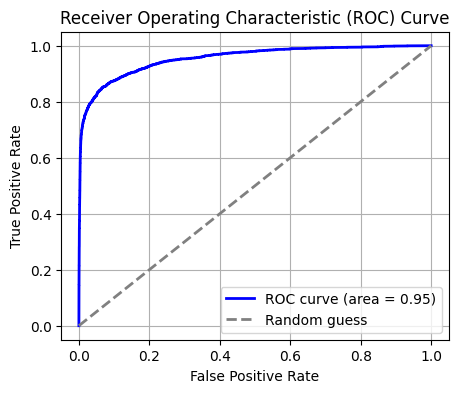

In [70]:
y_prob = xgb_random.predict_proba(X_val)[:, 1]  # Probabilidades para la clase positiva
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

<Figure size 500x400 with 0 Axes>

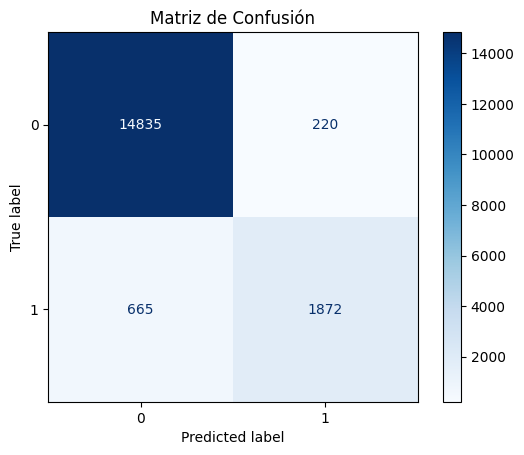

In [71]:
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_random.classes_)

plt.figure(figsize=(5, 4))
disp.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusión')
plt.show()

In [72]:
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_val, y_pred)

In [73]:
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Confusion Matrix:\n{conf_matrix}')
print('ROC-AUC score:',round(roc_auc_score(y_val, y_pred),4))

Accuracy: 0.9496930422919508
Precision: 0.9481181566819075
Recall: 0.9496930422919508
F1 Score: 0.9476412938253589
Confusion Matrix:
[[14835   220]
 [  665  1872]]
ROC-AUC score: 0.8616


In [74]:
xgb = XGBClassifier(**xgb_random.best_params_)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_val)

In [75]:
num_features = vars_num

# Recuperar nombres de las columnas categóricas (OneHotEncoded)
cat_features = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(vars_cat)

# Combinar todos los nombres de columnas procesadas
all_features = list(num_features) + list(cat_features)

In [76]:
X_train_df = pd.DataFrame(X_train, columns=all_features)
X_val_df = pd.DataFrame(X_val, columns=all_features)

In [77]:
# Supongamos que tienes un modelo entrenado llamado `model`
feature_importances = xgb.feature_importances_

# Crear un DataFrame con las importancias
feature_importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': feature_importances
})

# Ordenar por importancia
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df.head(10))

                          Feature  Importance
25                   loan_grade_D    0.269238
15     person_home_ownership_RENT    0.185298
5             loan_percent_income    0.097523
8               income_loan_ratio    0.047081
14      person_home_ownership_OWN    0.043574
19            loan_intent_MEDICAL    0.041984
18    loan_intent_HOMEIMPROVEMENT    0.041044
16  loan_intent_DEBTCONSOLIDATION    0.040595
24                   loan_grade_C    0.037973
4                   loan_int_rate    0.033008


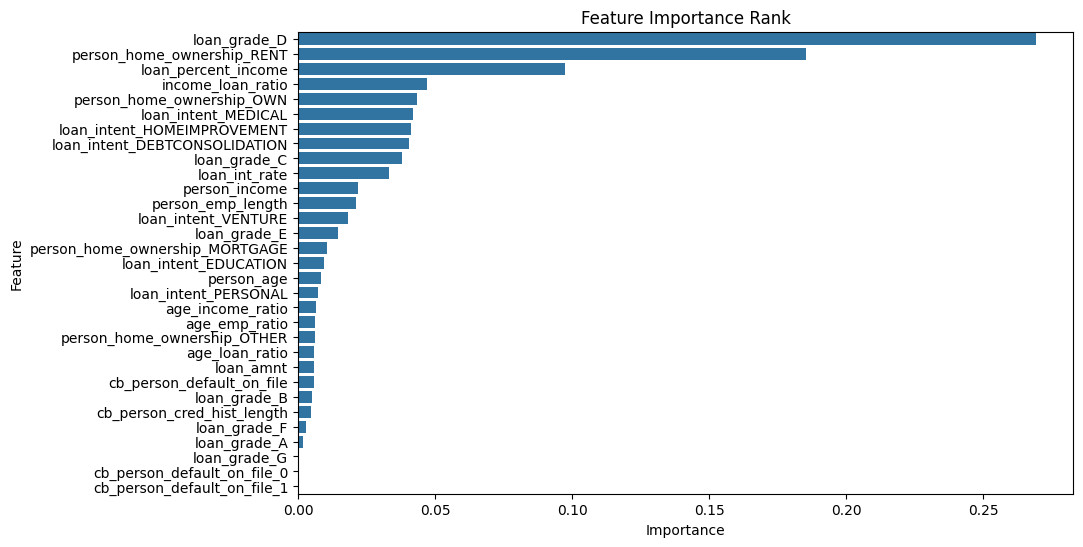

In [78]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance Rank')
plt.show()

# Test

In [79]:
# test = preprocessor.transform(test)

# y_pred_prob = xgb_random.predict_proba(test)[:,1]
# predictions = pd.DataFrame(y_pred_prob)


# predictions = predictions.reset_index().rename(columns={
#     'index':'id',
#     0:'loan_status'
# })

# predictions['id'] = test_id

In [80]:
# predictions.to_csv("xgboost_best_params.csv", index=False)